In [1]:
import sys
import gym
import torch
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import slimevolleygym

gym.logger.set_level(40)
sys.path.append('../')
from maddpg import MADDPGAgent
env = gym.make("SlimeVolley-v0")

In [2]:
o_dim = env.observation_space.shape[0]
a_dim = env.action_space.n
print('State shape: ', o_dim)
print('Action shape: ', a_dim)

State shape:  12
Action shape:  3


In [3]:
num_agents = 2
x_dim = o_dim * num_agents

# agent parameters
LR_ACTOR = 1e-4         # actor learning rate
LR_CRITIC = 1e-4        # critic learning rate
BATCH_SIZE = 16        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 0.001             # for soft update of target parameters
BUFFER_SIZE = int(1e6)  # replay buffer size     


maddpg = MADDPGAgent(num_agents, x_dim, o_dim, a_dim,
                     lr_actor = LR_ACTOR, lr_critic = LR_CRITIC, 
                     batch_size = BATCH_SIZE, gamma = GAMMA, tau = TAU, 
                     buffer_size = BUFFER_SIZE, seed = 1234)

In [4]:
maddpg.agents[0].actor

Actor(
  (fc1): Linear(in_features=12, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=3, bias=True)
)

In [5]:
maddpg.agents[0].critic

Critic(
  (fcs1): Linear(in_features=24, out_features=256, bias=True)
  (fc2): Linear(in_features=262, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1, bias=True)
)

In [6]:
# parameters for training
NUM_EPISODES = 5
PRINT_EVERY = 50
TMAX = 500

eps_start = 1.0
eps_end = 0.1
eps_decay = 0.99

In [7]:
score_list = []
score_window = deque(maxlen = PRINT_EVERY)  
eps = eps_start
for e in range(1, NUM_EPISODES+1):
    
    maddpg.reset() # reset noise process
    
    obs1 = env.reset() # reset environment
    obs2 = obs1
    state = np.array([obs1, obs2])
    
    score = 0
    for t in range(TMAX):
        action = maddpg.get_actions(state, eps)
        
        obs1, r1, done, info = env.step(action)
        obs2 = info['otherObs']
        next_state =  np.array([obs1, obs2])
        
        reward = [r1, r1]
        
        maddpg.step(state, action, reward, next_state, [done]*2)
        
        state = next_state
        score += r1
        if done:
            break
            
    eps = max(eps_end, eps_decay*eps) # decrease epsilon
    score_window.append(score)
    mean_score = np.mean(score_window)
    score_list.append([score, mean_score])
    
    print('\r\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score), end = "")
    
    if e % PRINT_EVERY == 0:
        print('\rEpisode {}\tsum of rewards {:8.2f}'.format(e, mean_score))
        

Episode 5	sum of rewards    -3.80

In [11]:
maddpg.iter

4548

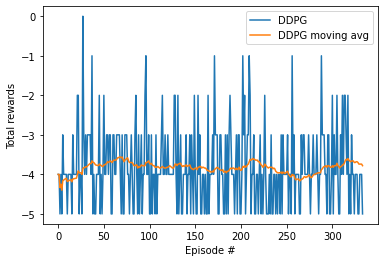

In [12]:
score1 = np.asarray(score_list).T

fig = plt.figure()
plt.plot(np.arange(score1.shape[1]), score1[0], label = "DDPG")
plt.plot(np.arange(score1.shape[1]), score1[1], label = "DDPG moving avg")
plt.ylabel('Total rewards')
plt.xlabel('Episode #')
plt.legend()
plt.show()

In [19]:
from gym.wrappers import Monitor
def wrap_env(env):
    env = Monitor(env, '../video', force=True)
    return env

env = wrap_env(gym.make("SlimeVolley-v0"))

obs1 = env.reset() # reset environment
obs2 = obs1
state = [obs1, obs2]
while True:
    action, _ = agent.get_actions(state)
    obs1, r1, done, info = env.step(action)
    obs2 = info['otherObs']
    state = [obs1, obs2]
    if done:
        break

env.close()